# Several Items

## Library Importing

In [1]:
import random
import re
import seaborn as sns
import numpy as np
import datetime as dt
import time
import pandas as pd
import os  
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import *
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping
from IPython.display import clear_output

## Extra Functions

In [2]:
def full_stats(data):
    mean = data.mean()
    median = data.quantile(0.50)
    minimum = data.min()
    maximum = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    big_outliers = q3 + (1.5*iqr)
    small_outliers = q1 - (1.5*iqr)
    stdev = np.std(data)
    variance = np.var(data)
    deviations = data - mean
    display(deviations)
    #sns.boxplot(data)
    report = pd.DataFrame(data={'minimum':[minimum],
                                'q1':[q1],
                                'median':[median],
                                'q3':[q3],
                                'maximum':[maximum],
                                'iqr':[iqr],
                                'big_outliers':[big_outliers],
                                'small_outliers':[small_outliers],
                                'standard_deviation':[stdev],
                                'variance':[variance]})
    return report

In [3]:
def get_stats(data):
    count = data.count()
    mean = data.mean()
    median = data.quantile(0.50)
    minimum = data.min()
    maximum = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    big_outliers = q3 + (1.5*iqr)
    small_outliers = q1 - (1.5*iqr)
    stdev = np.std(data)
    variance = np.var(data)
    deviations = abs(data - mean)
    mad = deviations.mean()
    return [count,minimum,q1,median,q3,maximum,iqr,big_outliers,small_outliers,stdev,variance,mad]

In [4]:
def get_scores(model, features, target, predictions):
    score = model.score(features, target)
    avg_volume = sum(predictions)/len(predictions)
    r2 = r2_score(target,predictions)
    mse = mean_squared_error(target,predictions)
    mae = mean_absolute_error(target,predictions)
    rmse = mse**0.5
    return score, avg_volume, r2, mse, mae, rmse

In [5]:
def cv_test(df,features,target):
    scores = []
    rmses=[]
    
    sample_size = int(len(df) / 5)

    for i in range(0, len(df), sample_size):
        valid_indexes = list(range(i, i + sample_size))
        train_indexes = list(range(0, i)) + list(range(i + sample_size, len(df)))

        features_train = features.iloc[train_indexes]
        features_valid = features.iloc[valid_indexes]

        target_train = target.iloc[train_indexes]
        target_valid = target.iloc[valid_indexes]

        model = LinearRegression().fit(features_train, target_train)
        score = model.score(features_valid, target_valid)
        predictions = model.predict(features_valid)
        rmses.append(mean_squared_error(target_valid,predictions)**0.5)
        scores.append(score)
    return round(sum(scores)/len(scores),3),round(sum(rmses)/len(rmses),3)

In [6]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [7]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [8]:
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    data['previous_day'] = data['num_orders'].shift(24)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['next_hour'] = data['num_orders'].shift(-1)
    
    data = data.dropna()
    return data

In [9]:
def rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    return mse**0.5

In [10]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric=metric).fit(df[feature_names].to_numpy())
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [11]:
def build_knc(train, target, test, n_neighbors):
    np.random.seed(42)
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    knc.fit(features_train, target)
    y_pred = knc.predict(test)
    return y_pred

In [12]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')  

In [13]:
def fix_column_names(df):
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.lower()
    return df

## Load/Prep Data

In [14]:
df = pd.read_csv('Sample_Grocery_Features.csv', index_col=[0], parse_dates=True, error_bad_lines=False)

In [15]:
df = fix_column_names(df)
df.head()

,price_purchased,price_sold,quantity_for_stock,date_purchased_by_store,date_put_on_shelf,date_purchased_by_customer,store_name,weekly_sales,monthly_sales,quarterly_sales,yearly_sales,expiration_date,seasonal?,initial_release_date,brand,subcategory,allergy_warning,damaged?,on_sale
Item ID,,,,,,,,,,,,,,,,,,,
6731809754,$3.79,$5.94,442,4/3/2020,4/4/2020,4/6/2020,NaN,"$4,324.80","$18,435.38","$61,820.04","$229,184.87",4/3/2022,NO,1/20/1962,NaN,NaN,YES,NO,NO
4218221611,$6.74,$8.10,250,10/22/2019,10/23/2019,10/28/2019,NaN,"$2,263.66","$7,368.30","$21,322.42","$76,004.50",10/21/2021,NO,1/13/2000,NaN,NaN,NO,NO,NO
9635054334,$3.16,$2.57,177,2/10/2020,2/11/2020,2/16/2020,NaN,$631.17,"$2,529.44","$7,802.24","$35,806.17",2/9/2022,YES,5/13/1966,NaN,NaN,NO,NO,YES
2210022356,$2.16,$2.52,175,3/12/2018,3/13/2018,3/13/2018,NaN,$624.36,"$2,982.45","$9,462.60","$32,419.74",3/11/2020,NO,4/9/1962,NaN,NaN,NO,NO,NO
9128591178,$6.10,$8.15,495,11/10/2017,11/11/2017,11/15/2017,NaN,"$4,435.49","$20,994.26","$69,897.37","$250,220.98",11/10/2019,NO,10/17/1965,NaN,NaN,YES,NO,NO


In [16]:
df = df.dropna(how='any', axis=1)

In [17]:
df = df.sort_index()

In [18]:
for col in ['seasonal?','allergy_warning','damaged?','on_sale']:
    df[col] = df[col].map({'YES': 1, 'NO': 0})
del col

In [19]:
for col in ['price_purchased','price_sold','weekly_sales','monthly_sales','quarterly_sales','yearly_sales']:
    df[col] = df[col].str.split("$").str[1]
    df[col] = df[col].str.replace(',','')
    df[col] = df[col].astype('float64')
del col

In [20]:
for col in df.columns:
    if 'date' in col:
        df[col] = pd.to_datetime(df[col])
df.info()
del col

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1000140823 to 9999873529
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   price_purchased             50000 non-null  float64       
 1   price_sold                  50000 non-null  float64       
 2   quantity_for_stock          50000 non-null  int64         
 3   date_purchased_by_store     50000 non-null  datetime64[ns]
 4   date_put_on_shelf           50000 non-null  datetime64[ns]
 5   date_purchased_by_customer  50000 non-null  datetime64[ns]
 6   weekly_sales                50000 non-null  float64       
 7   monthly_sales               50000 non-null  float64       
 8   quarterly_sales             50000 non-null  float64       
 9   yearly_sales                50000 non-null  float64       
 10  expiration_date             50000 non-null  datetime64[ns]
 11  seasonal?                   50000 non-nu

## Model Training

### Scale/Split Data

In [21]:
random_state = 42

In [22]:
scaler = StandardScaler()
encoder = LabelEncoder()

In [23]:
features = df.drop('price_sold',axis=1)
target = df['price_sold']

In [24]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, 
                                                                            random_state=random_state)

In [25]:
features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()

In [26]:
for col in df.columns:
    if 'date' in col:
        features_train_scaled[col] = encoder.fit_transform(features_train_scaled[col])
        features_test_scaled[col] = encoder.fit_transform(features_test_scaled[col])

In [27]:
scaler.fit(features_train_scaled)

StandardScaler()

In [28]:
features_train_scaled = scaler.transform(features_train_scaled)
features_test_scaled = scaler.transform(features_test_scaled)

In [29]:
del scaler,encoder

### Dummy Test

In [30]:
dr = DummyRegressor(strategy='median')

In [31]:
start = time.time()
dr.fit(features_train_scaled, target_train)
dr_fit_time = round(time.time()-start,2)

In [32]:
dr_predictions = dr.predict(features_test_scaled)
dr_rmse = rmse(target_test, dr_predictions)

In [34]:
features_test['dr_error'] = (dr_predictions-target_test)

In [35]:
features_test['dr_predictions'] = dr_predictions

### Linear Regression

In [36]:
lr = LinearRegression()
start = time.time()
lr.fit(features_train_scaled, target_train)
lr_fit_time = round(time.time()-start,2)

In [37]:
lr_predictions = lr.predict(features_test_scaled)
lr_rmse = rmse(target_test, lr_predictions)

In [39]:
features_test['lr_predictions'] = np.round(lr_predictions,2)

In [40]:
features_test['lr_error'] = np.round((lr_predictions-target_test),2)

### Other Models

#### Random Forest Regressor

In [41]:
rfr = RandomForestRegressor(random_state=random_state,
                            n_estimators=100,
                            max_features=0.3,
                            verbose=False,
                            warm_start=True)

In [42]:
start = time.time()
rfr.fit(features_train_scaled, target_train)
rfr_fit_time = round(time.time()-start,2)

In [43]:
rfr_predictions = rfr.predict(features_test_scaled)
rfr_rmse = rmse(target_test,rfr_predictions)

In [45]:
features_test['rfr_predictions'] = np.round(rfr_predictions,2)
features_test['rfr_error'] = np.round((rfr_predictions-target_test),2)

#### Decision Tree Regressor

In [46]:
dtr = DecisionTreeRegressor(random_state=random_state,
                            splitter='best',
                            max_features=None)

In [47]:
start = time.time()
dtr.fit(features_train_scaled, target_train)
dtr_fit_time = round(time.time()-start,2)

In [48]:
dtr_predictions = dtr.predict(features_test_scaled)
dtr_rmse = rmse(target_test,dtr_predictions)

In [50]:
features_test['dtr_predictions'] = np.round(dtr_predictions,2)
features_test['dtr_error'] = np.round((dtr_predictions-target_test),2)

#### LGBM Regressor

In [51]:
eval_set = [(features_test_scaled, target_test)]

In [52]:
lgbm = LGBMRegressor(random_state=random_state,
                     early_stopping_round=5,
                     num_iterations=1000,
                     n_estimators=100,
                     max_depth=5,
                     num_leaves=31,
                     learning_rate=0.01)

In [53]:
start = time.time()
lgbm.fit(features_train_scaled, 
         target_train,
         eval_metric='error',
         eval_set=eval_set)
lgbm_fit_time = round(time.time()-start,2)

[1]	valid_0's l2: 5.58872
[2]	valid_0's l2: 5.48442
[3]	valid_0's l2: 5.38219
[4]	valid_0's l2: 5.28195
[5]	valid_0's l2: 5.18369
[6]	valid_0's l2: 5.08739
[7]	valid_0's l2: 4.99304
[8]	valid_0's l2: 4.90053
[9]	valid_0's l2: 4.80986
[10]	valid_0's l2: 4.72098
[11]	valid_0's l2: 4.63387
[12]	valid_0's l2: 4.54846
[13]	valid_0's l2: 4.46477
[14]	valid_0's l2: 4.38272
[15]	valid_0's l2: 4.30231
[16]	valid_0's l2: 4.2235
[17]	valid_0's l2: 4.14627
[18]	valid_0's l2: 4.07054
[19]	valid_0's l2: 3.99631
[20]	valid_0's l2: 3.92359
[21]	valid_0's l2: 3.85229
[22]	valid_0's l2: 3.7824
[23]	valid_0's l2: 3.71392
[24]	valid_0's l2: 3.64678
[25]	valid_0's l2: 3.58099
[26]	valid_0's l2: 3.51649
[27]	valid_0's l2: 3.45322
[28]	valid_0's l2: 3.39126
[29]	valid_0's l2: 3.33052
[30]	valid_0's l2: 3.27094
[31]	valid_0's l2: 3.21261
[32]	valid_0's l2: 3.15538
[33]	valid_0's l2: 3.09933
[34]	valid_0's l2: 3.04438
[35]	valid_0's l2: 2.99044
[36]	valid_0's l2: 2.93765
[37]	valid_0's l2: 2.88584
[38]	valid_0

In [54]:
lgbm_predictions = lgbm.predict(features_test_scaled)
lgbm_rmse = rmse(target_test,lgbm_predictions)

In [55]:
features_test['lgbm_predictions'] = np.round(lgbm_predictions,2)
features_test['lgbm_error'] = np.round((lgbm_predictions-target_test),2)

#### CatBoostRegressor

In [56]:
cbr = CatBoostRegressor(random_state=random_state,
                        early_stopping_rounds=5,
                        iterations=1000,
                        max_depth=None,
                        num_leaves=31,
                        learning_rate=0.01)

In [57]:
start = time.time()
cbr.fit(features_train_scaled, 
        target_train,
        eval_set=eval_set,
        silent=True)
cbr_fit_time = round(time.time()-start,2)

In [58]:
cbr_predictions = lgbm.predict(features_test_scaled)
cbr_rmse = rmse(target_test,lgbm_predictions)

In [60]:
features_test['cbr_predictions'] = np.round(cbr_predictions,2)
features_test['cbr_error'] = np.round((cbr_predictions-target_test),2)

## Error Analysis

In [92]:
pd.concat([target_test,features_test[['dr_predictions',
                                     'lr_predictions',
                                     'rfr_predictions',
                                     'lgbm_predictions',
                                     'cbr_predictions']]],
                                     join='outer',
                                     axis=1).sort_index().head(5)

,price_sold,dr_predictions,lr_predictions,rfr_predictions,lgbm_predictions,cbr_predictions
Item ID,,,,,,
1000653731,4.86,4.69,5.99,5.95,5.99,5.99
1000967045,4.23,4.69,4.26,4.34,4.28,4.28
1001151067,5.24,4.69,6.09,5.24,5.40,5.40
1009039405,3.13,4.69,3.49,3.44,3.34,3.34
1009650054,6.14,4.69,6.52,6.74,6.64,6.64


In [62]:
sns.set(rc={'figure.figsize':(14,8)})

In [63]:
rmse_fit = pd.DataFrame({'RMSE':[dr_rmse,lr_rmse,rfr_rmse,dtr_rmse,lgbm_rmse,cbr_rmse],
                         'Fit Time':[dr_fit_time,lr_fit_time,rfr_fit_time,dtr_fit_time,lgbm_fit_time,cbr_fit_time]},
                        index=['Dummy','Linear','Random Forest','Decision Tree','Light Gradient Boost','Cat Boost'])

In [64]:
rmse_fit

,RMSE,Fit Time
Dummy,2.393998,0.00
Linear,0.610317,0.01
Random Forest,0.500453,17.96
Decision Tree,0.704177,0.91
Light Gradient Boost,0.492373,18.49
Cat Boost,0.492373,12.71


In [65]:
rmse_fit.T

,Dummy,Linear,Random Forest,Decision Tree,Light Gradient Boost,Cat Boost
RMSE,2.393998,0.610317,0.500453,0.704177,0.492373,0.492373
Fit Time,0.000000,0.010000,17.960000,0.910000,18.490000,12.710000


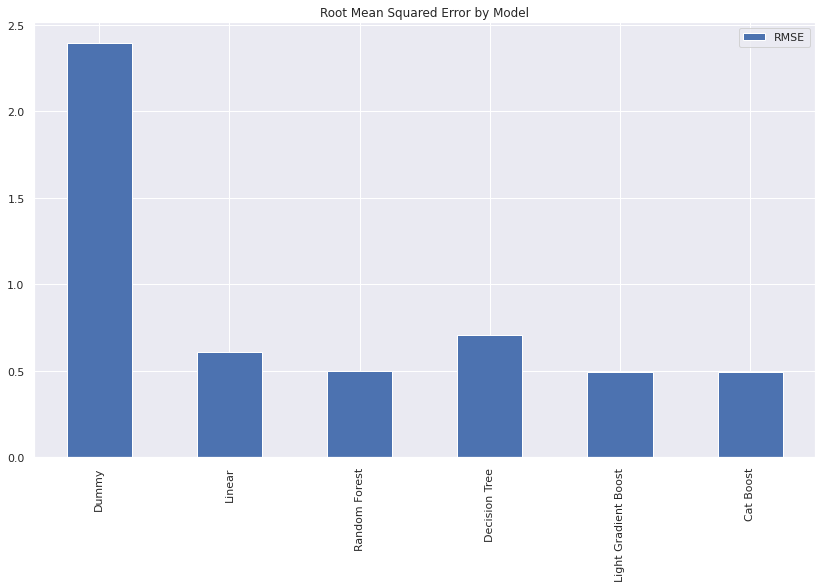

In [66]:
ax = rmse_fit[['RMSE']].plot(kind='bar',title='Root Mean Squared Error by Model')
ax.figure.savefig("RMSE_by_Model.png")
ax.figure.savefig("RMSE_by_Model.pdf")

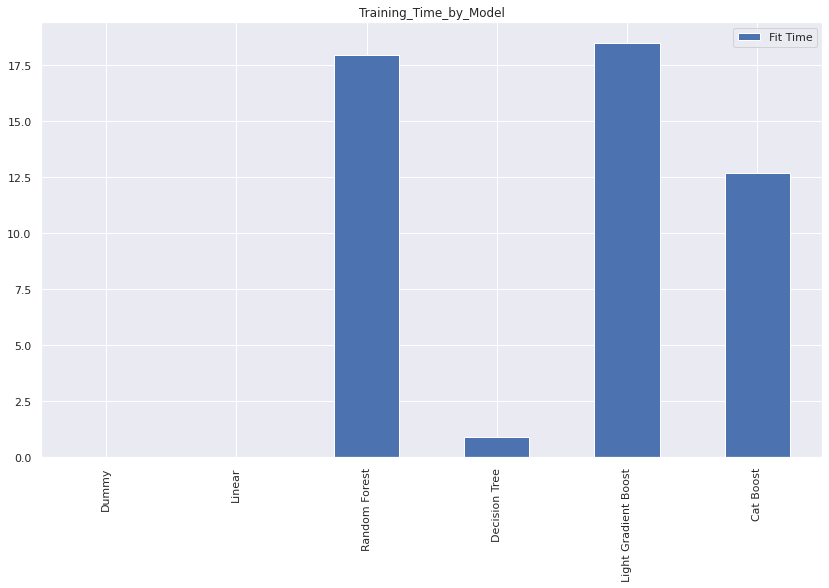

In [67]:
ax = rmse_fit[['Fit Time']].plot(kind='bar',title='Training_Time_by_Model')
ax.figure.savefig("Training_Time_by_Model.png")
ax.figure.savefig("Training_Time_by_Model.pdf")

In [68]:
df_price_analysis = pd.concat([target_test,features_test[['dr_predictions','dr_error','lr_predictions','lr_error','dtr_predictions','dtr_error','cbr_predictions',
                                                    'rfr_predictions','rfr_error','lgbm_predictions','lgbm_error','cbr_error']]],
                       axis=1,
                       join='outer')
df_price_analysis = df_price_analysis.sort_index()

In [69]:
df_feature_importance_analysis = pd.DataFrame(data={'cbr':cbr.feature_importances_,
                                                    'lgbm':lgbm.feature_importances_,
                                                    'rfr':rfr.feature_importances_,
                                                    'dtr':dtr.feature_importances_},
                                              index=features_train.columns)

In [70]:
for col in df_feature_importance_analysis.columns:
    total = df_feature_importance_analysis[col].sum()
    df_feature_importance_analysis[col] = df_feature_importance_analysis[col]/total

In [71]:
df_feature_importance_analysis['sum'] = (df_feature_importance_analysis['cbr'] + df_feature_importance_analysis['lgbm'] + 
                                        df_feature_importance_analysis['rfr'] + df_feature_importance_analysis['dtr'])

In [72]:
df_feature_importance_analysis.sort_values('sum',ascending=False)

,cbr,lgbm,rfr,dtr,sum
price_purchased,0.513775,0.282415,0.419475,0.790889,2.006554
on_sale,0.412205,0.064682,0.055987,0.154653,0.687527
weekly_sales,0.024330,0.222033,0.140401,0.012620,0.399383
quantity_for_stock,0.021724,0.187597,0.077512,0.011032,0.297865
monthly_sales,0.009012,0.039106,0.111505,0.005571,0.165194
quarterly_sales,0.004306,0.028171,0.079164,0.005144,0.116786
yearly_sales,0.003366,0.041627,0.051972,0.005249,0.102213
seasonal?,0.005316,0.020461,0.027794,0.001684,0.055255
initial_release_date,0.000185,0.040626,0.005627,0.005550,0.051988
damaged?,0.005439,0.027986,0.014030,0.000308,0.047763


In [73]:
df_feature_importance_analysis.sort_values('cbr',ascending=False)

,cbr,lgbm,rfr,dtr,sum
price_purchased,0.513775,0.282415,0.419475,0.790889,2.006554
on_sale,0.412205,0.064682,0.055987,0.154653,0.687527
weekly_sales,0.024330,0.222033,0.140401,0.012620,0.399383
quantity_for_stock,0.021724,0.187597,0.077512,0.011032,0.297865
monthly_sales,0.009012,0.039106,0.111505,0.005571,0.165194
damaged?,0.005439,0.027986,0.014030,0.000308,0.047763
seasonal?,0.005316,0.020461,0.027794,0.001684,0.055255
quarterly_sales,0.004306,0.028171,0.079164,0.005144,0.116786
yearly_sales,0.003366,0.041627,0.051972,0.005249,0.102213
initial_release_date,0.000185,0.040626,0.005627,0.005550,0.051988


In [74]:
df_feature_importance_analysis.sort_values('lgbm',ascending=False)

,cbr,lgbm,rfr,dtr,sum
price_purchased,0.513775,0.282415,0.419475,0.790889,2.006554
weekly_sales,0.024330,0.222033,0.140401,0.012620,0.399383
quantity_for_stock,0.021724,0.187597,0.077512,0.011032,0.297865
on_sale,0.412205,0.064682,0.055987,0.154653,0.687527
yearly_sales,0.003366,0.041627,0.051972,0.005249,0.102213
initial_release_date,0.000185,0.040626,0.005627,0.005550,0.051988
monthly_sales,0.009012,0.039106,0.111505,0.005571,0.165194
date_purchased_by_store,0.000095,0.031396,0.003884,0.001773,0.037148
quarterly_sales,0.004306,0.028171,0.079164,0.005144,0.116786
damaged?,0.005439,0.027986,0.014030,0.000308,0.047763


In [75]:
df_feature_importance_analysis.sort_values('rfr',ascending=False)

,cbr,lgbm,rfr,dtr,sum
price_purchased,0.513775,0.282415,0.419475,0.790889,2.006554
weekly_sales,0.024330,0.222033,0.140401,0.012620,0.399383
monthly_sales,0.009012,0.039106,0.111505,0.005571,0.165194
quarterly_sales,0.004306,0.028171,0.079164,0.005144,0.116786
quantity_for_stock,0.021724,0.187597,0.077512,0.011032,0.297865
on_sale,0.412205,0.064682,0.055987,0.154653,0.687527
yearly_sales,0.003366,0.041627,0.051972,0.005249,0.102213
seasonal?,0.005316,0.020461,0.027794,0.001684,0.055255
damaged?,0.005439,0.027986,0.014030,0.000308,0.047763
initial_release_date,0.000185,0.040626,0.005627,0.005550,0.051988


In [76]:
df_feature_importance_analysis.sort_values('dtr',ascending=False)

,cbr,lgbm,rfr,dtr,sum
price_purchased,0.513775,0.282415,0.419475,0.790889,2.006554
on_sale,0.412205,0.064682,0.055987,0.154653,0.687527
weekly_sales,0.024330,0.222033,0.140401,0.012620,0.399383
quantity_for_stock,0.021724,0.187597,0.077512,0.011032,0.297865
monthly_sales,0.009012,0.039106,0.111505,0.005571,0.165194
initial_release_date,0.000185,0.040626,0.005627,0.005550,0.051988
yearly_sales,0.003366,0.041627,0.051972,0.005249,0.102213
quarterly_sales,0.004306,0.028171,0.079164,0.005144,0.116786
date_purchased_by_store,0.000095,0.031396,0.003884,0.001773,0.037148
seasonal?,0.005316,0.020461,0.027794,0.001684,0.055255


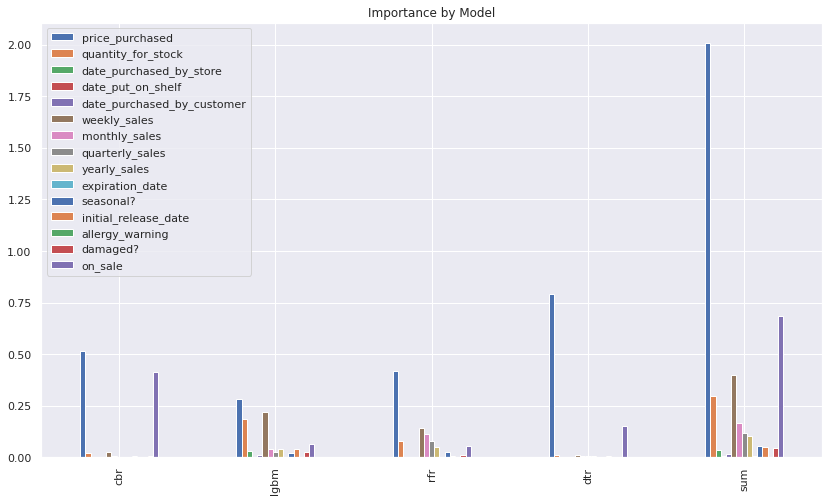

In [77]:
ax = df_feature_importance_analysis.T.plot(kind='bar',title='Importance by Model')
ax.figure.savefig("Importance_By_Model_Bar.png")
ax.figure.savefig("Importance_By_Model_Bar.pdf")

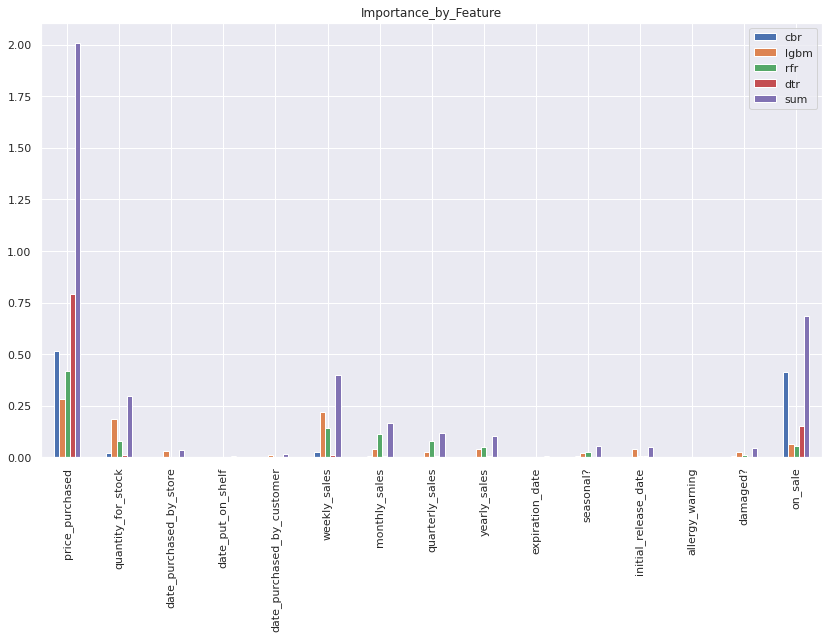

In [78]:
ax = df_feature_importance_analysis.plot(kind='bar',title='Importance_by_Feature')
ax.figure.savefig("Importance_By_Feature_Bar.png")
ax.figure.savefig("Importance_By_Feature_Bar.pdf")

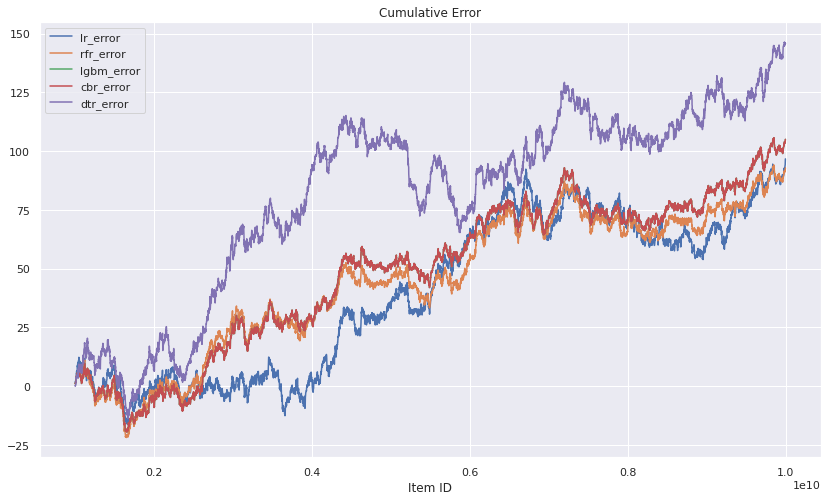

In [79]:
ax = df_price_analysis[
     ['lr_error','rfr_error','lgbm_error','cbr_error','dtr_error']
     ].cumsum().plot(
     title='Cumulative Error',
     alpha=1)
ax.figure.savefig("Error_All_Prices_Line.png")
ax.figure.savefig("Error_All_Prices_Line.pdf")

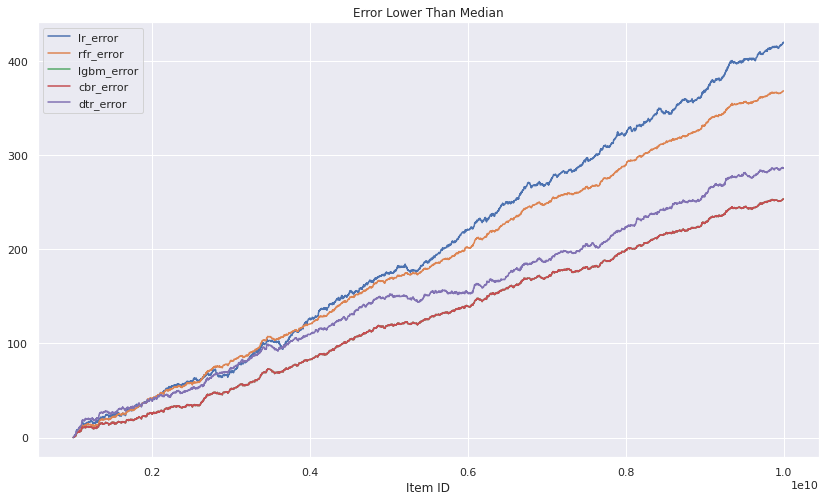

In [80]:
ax = df_price_analysis[df_price_analysis['price_sold']<df_price_analysis['price_sold'].median()][
    ['lr_error','rfr_error','lgbm_error','cbr_error','dtr_error']
    ].cumsum().plot(
    title='Error Lower Than Median',
    alpha=1)
ax.figure.savefig("Error_Small_Prices_Line.png")
ax.figure.savefig("Error_Small_Prices_Line.pdf")

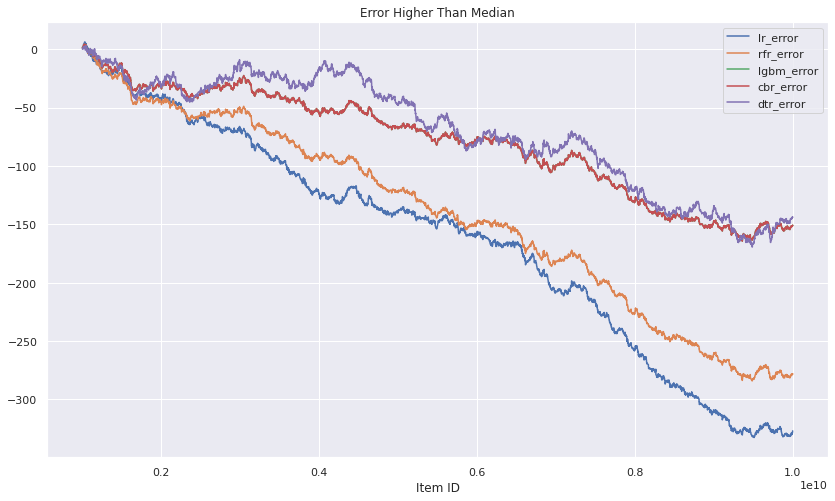

In [81]:
ax = df_price_analysis[df_price_analysis['price_sold']>df_price_analysis['price_sold'].median()][
    ['lr_error','rfr_error','lgbm_error','cbr_error','dtr_error']
    ].cumsum().plot(
    title='Error Higher Than Median',
    alpha=1)
ax.figure.savefig("Error_Large_Prices_Line.png")
ax.figure.savefig("Error_Large_Prices_Line.pdf")

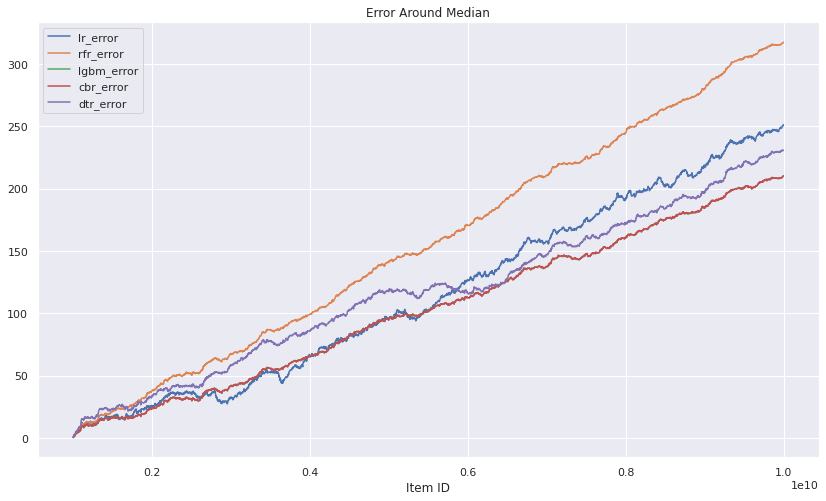

In [82]:
ax = df_price_analysis[df_price_analysis['price_sold']<abs(df_price_analysis['price_sold'].median()-0.5)][
    ['lr_error','rfr_error','lgbm_error','cbr_error','dtr_error']
    ].cumsum().plot(
    title='Error Around Median',
    alpha=1)
ax.figure.savefig("Error_Average_Prices_Line.png")
ax.figure.savefig("Error_Average_Prices_Line.pdf")

In [83]:
df_feature_importance_analysis.to_csv("Importance_by_Feature.csv")

In [84]:
df_feature_importance_analysis.T.to_csv("Importance_by_Model.csv")

In [85]:
df_price_analysis.to_csv("Price_With_Predictions.csv")